# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

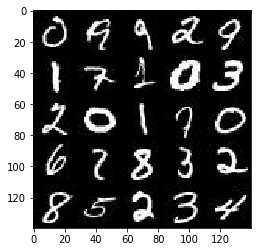

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

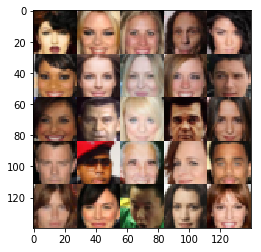

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return (
        tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real'),
        tf.placeholder(tf.float32, (None, z_dim), name='input_z'),
        tf.placeholder(tf.float32, name='learning_rate')
    )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [28]:
def discriminator(images, reuse=False, n_units=128, alpha=0.2, stddev=0.05):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images,
                              n_units,
                              5,
                              strides=2,
                              padding="same",
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha * x1, x1)
    
        x2 = tf.layers.conv2d(relu1,
                              n_units * 2,
                              5,
                              strides=2,
                              padding="same",
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
       
        x3 = tf.layers.conv2d(relu2,
                              n_units * 4,
                              5,
                              strides=2,
                              padding="same",
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flattened_dim = 4 * 4 * (n_units * 4)
        
        flat = tf.reshape(relu3, (-1, flattened_dim))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, n_units=128, stddev=0.05):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7 * 7 * n_units * 4)
        x1 = tf.reshape(x1, (-1, 7, 7, n_units * 4))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1,
                                        n_units * 2,
                                        5,
                                        strides=2,
                                        padding="same",
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2,
                                        n_units,
                                        5,
                                        strides=2,
                                        padding="same",
                                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
       
        logits = tf.layers.conv2d_transpose(x3,
                                            out_channel_dim,
                                            3,
                                            strides=1,
                                            padding="same",
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)
        
    return out 



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(
                          logits=d_logits_real,
                          labels=tf.ones_like(d_logits_real) * (1 - smooth)
                      )
                  )
    
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(
                          logits=d_logits_fake,
                          labels=tf.zeros_like(d_logits_fake)
                      )
                  )
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_fake,
                    labels=tf.ones_like(d_logits_fake)
                )
             )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                         beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                         beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width,
                                           image_height,
                                           image_channels,
                                           z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    show_step = 100
    loss_step = 10
    num_img_to_show = 50
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # keep track of which step we're at
                # for displaying info
                steps += 1
                
                # input random noise
                input_z_rand = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                batch_images = 2 * batch_images
                
                # run optimizers
                _ = sess.run(d_opt,
                             feed_dict={
                                 input_real: batch_images,
                                 input_z: input_z_rand,
                                 lr: learning_rate
                             })
                _ = sess.run(g_opt, feed_dict={
                                        input_z: input_z_rand,
                                        lr: learning_rate
                                    })

                # dusplay info
                if steps % loss_step == 0:
                    train_loss_d = d_loss.eval({input_z: input_z_rand, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: input_z_rand})

                    print("Epoch: {curr} of {total}\t".format(curr=epoch_i + 1, total=epoch_count),
                          "Discriminator Loss: {:3f}\t".format(train_loss_d),
                          "Generator Loss: {:3f}".format(train_loss_g))

                # show current generated images
                if steps % show_step == 0:
                    show_generator_output(sess,
                                          num_img_to_show,
                                          input_z,
                                          image_channels,
                                          data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1 of 2	 Discriminator Loss: 0.838753	 Generator Loss: 1.432195
Epoch: 1 of 2	 Discriminator Loss: 1.606568	 Generator Loss: 0.515898
Epoch: 1 of 2	 Discriminator Loss: 2.191947	 Generator Loss: 0.276666
Epoch: 1 of 2	 Discriminator Loss: 1.522154	 Generator Loss: 1.208714
Epoch: 1 of 2	 Discriminator Loss: 2.254968	 Generator Loss: 2.417420
Epoch: 1 of 2	 Discriminator Loss: 1.596628	 Generator Loss: 1.874654
Epoch: 1 of 2	 Discriminator Loss: 1.592876	 Generator Loss: 1.231729
Epoch: 1 of 2	 Discriminator Loss: 1.551447	 Generator Loss: 1.487801
Epoch: 1 of 2	 Discriminator Loss: 1.206434	 Generator Loss: 1.403209
Epoch: 1 of 2	 Discriminator Loss: 1.421236	 Generator Loss: 0.773532


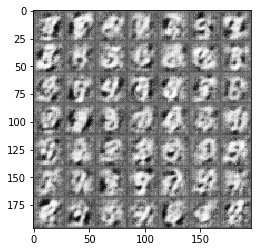

Epoch: 1 of 2	 Discriminator Loss: 1.407930	 Generator Loss: 1.201637
Epoch: 1 of 2	 Discriminator Loss: 1.335785	 Generator Loss: 1.109415
Epoch: 1 of 2	 Discriminator Loss: 1.256561	 Generator Loss: 1.546832
Epoch: 1 of 2	 Discriminator Loss: 1.059588	 Generator Loss: 1.420071
Epoch: 1 of 2	 Discriminator Loss: 1.057523	 Generator Loss: 1.070929
Epoch: 1 of 2	 Discriminator Loss: 1.104046	 Generator Loss: 0.922313
Epoch: 1 of 2	 Discriminator Loss: 1.075403	 Generator Loss: 1.611974
Epoch: 1 of 2	 Discriminator Loss: 0.978807	 Generator Loss: 1.001489
Epoch: 1 of 2	 Discriminator Loss: 0.899303	 Generator Loss: 1.452708
Epoch: 1 of 2	 Discriminator Loss: 1.137455	 Generator Loss: 2.066997


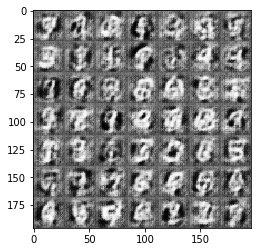

Epoch: 1 of 2	 Discriminator Loss: 1.156612	 Generator Loss: 0.708965
Epoch: 1 of 2	 Discriminator Loss: 1.286956	 Generator Loss: 2.172281
Epoch: 1 of 2	 Discriminator Loss: 1.268630	 Generator Loss: 1.986073
Epoch: 1 of 2	 Discriminator Loss: 1.248082	 Generator Loss: 1.910173
Epoch: 1 of 2	 Discriminator Loss: 1.208866	 Generator Loss: 0.724156
Epoch: 1 of 2	 Discriminator Loss: 1.410834	 Generator Loss: 0.579223
Epoch: 1 of 2	 Discriminator Loss: 1.359578	 Generator Loss: 1.678681
Epoch: 1 of 2	 Discriminator Loss: 1.218042	 Generator Loss: 0.808946
Epoch: 1 of 2	 Discriminator Loss: 1.336924	 Generator Loss: 0.607118
Epoch: 1 of 2	 Discriminator Loss: 1.226805	 Generator Loss: 0.801636


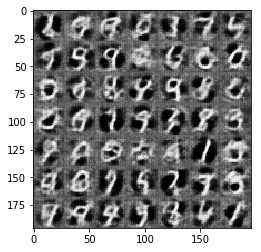

Epoch: 1 of 2	 Discriminator Loss: 1.130846	 Generator Loss: 0.794641
Epoch: 1 of 2	 Discriminator Loss: 1.339769	 Generator Loss: 1.746576
Epoch: 1 of 2	 Discriminator Loss: 1.174115	 Generator Loss: 0.757767
Epoch: 1 of 2	 Discriminator Loss: 1.166544	 Generator Loss: 0.950239
Epoch: 1 of 2	 Discriminator Loss: 1.023147	 Generator Loss: 1.077278
Epoch: 1 of 2	 Discriminator Loss: 1.215971	 Generator Loss: 1.485626
Epoch: 1 of 2	 Discriminator Loss: 1.283222	 Generator Loss: 1.419560
Epoch: 1 of 2	 Discriminator Loss: 1.300328	 Generator Loss: 1.410636
Epoch: 1 of 2	 Discriminator Loss: 1.266818	 Generator Loss: 1.638490
Epoch: 1 of 2	 Discriminator Loss: 1.070102	 Generator Loss: 1.075428


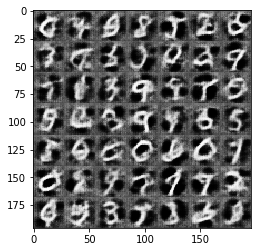

Epoch: 1 of 2	 Discriminator Loss: 1.331995	 Generator Loss: 1.756858
Epoch: 1 of 2	 Discriminator Loss: 1.118354	 Generator Loss: 1.001558
Epoch: 1 of 2	 Discriminator Loss: 1.200255	 Generator Loss: 0.746359
Epoch: 1 of 2	 Discriminator Loss: 1.079461	 Generator Loss: 1.027742
Epoch: 1 of 2	 Discriminator Loss: 1.784406	 Generator Loss: 0.320133
Epoch: 1 of 2	 Discriminator Loss: 1.152388	 Generator Loss: 0.808641
Epoch: 2 of 2	 Discriminator Loss: 1.305810	 Generator Loss: 2.119154
Epoch: 2 of 2	 Discriminator Loss: 1.136319	 Generator Loss: 1.391488
Epoch: 2 of 2	 Discriminator Loss: 1.412864	 Generator Loss: 2.108521
Epoch: 2 of 2	 Discriminator Loss: 1.082683	 Generator Loss: 1.482960


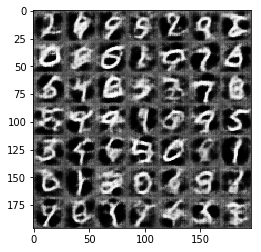

Epoch: 2 of 2	 Discriminator Loss: 1.197600	 Generator Loss: 1.576212
Epoch: 2 of 2	 Discriminator Loss: 1.064281	 Generator Loss: 0.993931
Epoch: 2 of 2	 Discriminator Loss: 1.284826	 Generator Loss: 0.595462
Epoch: 2 of 2	 Discriminator Loss: 1.185088	 Generator Loss: 1.790845
Epoch: 2 of 2	 Discriminator Loss: 1.164114	 Generator Loss: 0.739086
Epoch: 2 of 2	 Discriminator Loss: 1.091303	 Generator Loss: 0.891578
Epoch: 2 of 2	 Discriminator Loss: 1.567535	 Generator Loss: 0.413053
Epoch: 2 of 2	 Discriminator Loss: 1.284523	 Generator Loss: 0.624375
Epoch: 2 of 2	 Discriminator Loss: 1.151607	 Generator Loss: 0.765592
Epoch: 2 of 2	 Discriminator Loss: 1.501625	 Generator Loss: 0.454546


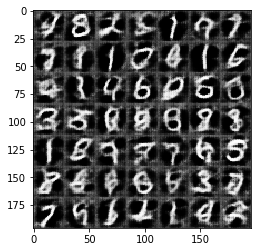

Epoch: 2 of 2	 Discriminator Loss: 1.018089	 Generator Loss: 1.323021
Epoch: 2 of 2	 Discriminator Loss: 1.063652	 Generator Loss: 1.207832
Epoch: 2 of 2	 Discriminator Loss: 1.055842	 Generator Loss: 1.180080
Epoch: 2 of 2	 Discriminator Loss: 1.191082	 Generator Loss: 1.727885
Epoch: 2 of 2	 Discriminator Loss: 1.067729	 Generator Loss: 0.805158
Epoch: 2 of 2	 Discriminator Loss: 1.014868	 Generator Loss: 0.989825
Epoch: 2 of 2	 Discriminator Loss: 1.180682	 Generator Loss: 0.724812
Epoch: 2 of 2	 Discriminator Loss: 1.024490	 Generator Loss: 1.264110
Epoch: 2 of 2	 Discriminator Loss: 1.153967	 Generator Loss: 1.646812
Epoch: 2 of 2	 Discriminator Loss: 1.014630	 Generator Loss: 1.111158


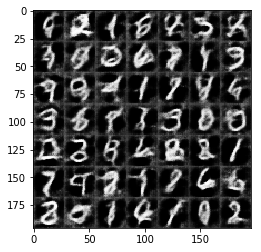

Epoch: 2 of 2	 Discriminator Loss: 1.185761	 Generator Loss: 1.664149
Epoch: 2 of 2	 Discriminator Loss: 1.020662	 Generator Loss: 0.917335
Epoch: 2 of 2	 Discriminator Loss: 0.962998	 Generator Loss: 1.069522
Epoch: 2 of 2	 Discriminator Loss: 1.018745	 Generator Loss: 1.429096
Epoch: 2 of 2	 Discriminator Loss: 0.991897	 Generator Loss: 0.994315
Epoch: 2 of 2	 Discriminator Loss: 0.999017	 Generator Loss: 1.092417
Epoch: 2 of 2	 Discriminator Loss: 1.259476	 Generator Loss: 1.762760
Epoch: 2 of 2	 Discriminator Loss: 0.851197	 Generator Loss: 1.405737
Epoch: 2 of 2	 Discriminator Loss: 1.058277	 Generator Loss: 1.342028
Epoch: 2 of 2	 Discriminator Loss: 1.035009	 Generator Loss: 0.938860


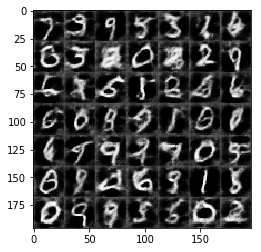

Epoch: 2 of 2	 Discriminator Loss: 1.351892	 Generator Loss: 0.535162
Epoch: 2 of 2	 Discriminator Loss: 1.082227	 Generator Loss: 0.934457
Epoch: 2 of 2	 Discriminator Loss: 0.975033	 Generator Loss: 1.229339
Epoch: 2 of 2	 Discriminator Loss: 3.763126	 Generator Loss: 5.169100
Epoch: 2 of 2	 Discriminator Loss: 1.063704	 Generator Loss: 1.142669
Epoch: 2 of 2	 Discriminator Loss: 0.969785	 Generator Loss: 1.121227
Epoch: 2 of 2	 Discriminator Loss: 1.100745	 Generator Loss: 1.067262
Epoch: 2 of 2	 Discriminator Loss: 1.015487	 Generator Loss: 0.988713
Epoch: 2 of 2	 Discriminator Loss: 3.547182	 Generator Loss: 4.628906
Epoch: 2 of 2	 Discriminator Loss: 0.964951	 Generator Loss: 0.982963


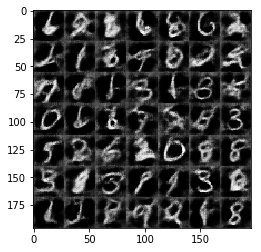

Epoch: 2 of 2	 Discriminator Loss: 1.196482	 Generator Loss: 0.671552
Epoch: 2 of 2	 Discriminator Loss: 1.004767	 Generator Loss: 1.056781
Epoch: 2 of 2	 Discriminator Loss: 1.014809	 Generator Loss: 0.973005


In [34]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1 of 1	 Discriminator Loss: 0.628778	 Generator Loss: 3.506762
Epoch: 1 of 1	 Discriminator Loss: 0.717876	 Generator Loss: 1.593989
Epoch: 1 of 1	 Discriminator Loss: 1.305735	 Generator Loss: 5.526711
Epoch: 1 of 1	 Discriminator Loss: 0.721513	 Generator Loss: 2.160143
Epoch: 1 of 1	 Discriminator Loss: 0.918877	 Generator Loss: 1.283917
Epoch: 1 of 1	 Discriminator Loss: 0.516384	 Generator Loss: 2.795675
Epoch: 1 of 1	 Discriminator Loss: 0.623146	 Generator Loss: 2.486305
Epoch: 1 of 1	 Discriminator Loss: 2.410897	 Generator Loss: 8.302919
Epoch: 1 of 1	 Discriminator Loss: 0.970013	 Generator Loss: 1.114929
Epoch: 1 of 1	 Discriminator Loss: 3.339918	 Generator Loss: 9.629464


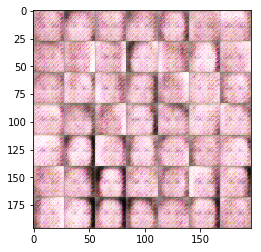

Epoch: 1 of 1	 Discriminator Loss: 0.724751	 Generator Loss: 3.276273
Epoch: 1 of 1	 Discriminator Loss: 1.205080	 Generator Loss: 5.216136
Epoch: 1 of 1	 Discriminator Loss: 1.392917	 Generator Loss: 7.355699
Epoch: 1 of 1	 Discriminator Loss: 0.671584	 Generator Loss: 1.707309
Epoch: 1 of 1	 Discriminator Loss: 1.113340	 Generator Loss: 4.115314
Epoch: 1 of 1	 Discriminator Loss: 0.686685	 Generator Loss: 1.601782
Epoch: 1 of 1	 Discriminator Loss: 1.076585	 Generator Loss: 5.309546
Epoch: 1 of 1	 Discriminator Loss: 0.721883	 Generator Loss: 1.455921
Epoch: 1 of 1	 Discriminator Loss: 1.136436	 Generator Loss: 0.886164
Epoch: 1 of 1	 Discriminator Loss: 1.442322	 Generator Loss: 0.512767


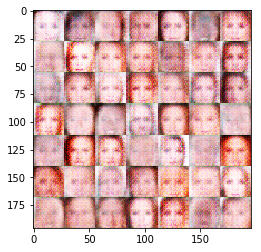

Epoch: 1 of 1	 Discriminator Loss: 1.954938	 Generator Loss: 0.287811
Epoch: 1 of 1	 Discriminator Loss: 0.911907	 Generator Loss: 1.060491
Epoch: 1 of 1	 Discriminator Loss: 1.609704	 Generator Loss: 4.751019
Epoch: 1 of 1	 Discriminator Loss: 0.829612	 Generator Loss: 1.188446
Epoch: 1 of 1	 Discriminator Loss: 1.963213	 Generator Loss: 4.818198
Epoch: 1 of 1	 Discriminator Loss: 0.532975	 Generator Loss: 2.839134
Epoch: 1 of 1	 Discriminator Loss: 0.598643	 Generator Loss: 1.742002
Epoch: 1 of 1	 Discriminator Loss: 1.515840	 Generator Loss: 0.454077
Epoch: 1 of 1	 Discriminator Loss: 2.289654	 Generator Loss: 0.191611
Epoch: 1 of 1	 Discriminator Loss: 0.882922	 Generator Loss: 1.539771


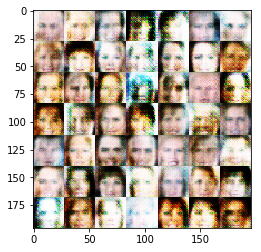

Epoch: 1 of 1	 Discriminator Loss: 1.074436	 Generator Loss: 1.337458
Epoch: 1 of 1	 Discriminator Loss: 0.899245	 Generator Loss: 1.083355
Epoch: 1 of 1	 Discriminator Loss: 0.808673	 Generator Loss: 4.859134
Epoch: 1 of 1	 Discriminator Loss: 1.253374	 Generator Loss: 6.932739
Epoch: 1 of 1	 Discriminator Loss: 1.054018	 Generator Loss: 3.821066
Epoch: 1 of 1	 Discriminator Loss: 0.562309	 Generator Loss: 5.448473
Epoch: 1 of 1	 Discriminator Loss: 0.700615	 Generator Loss: 1.388311
Epoch: 1 of 1	 Discriminator Loss: 1.047086	 Generator Loss: 2.494144
Epoch: 1 of 1	 Discriminator Loss: 0.889270	 Generator Loss: 0.972447
Epoch: 1 of 1	 Discriminator Loss: 0.910942	 Generator Loss: 0.999677


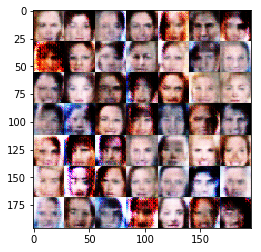

Epoch: 1 of 1	 Discriminator Loss: 0.654146	 Generator Loss: 1.762279
Epoch: 1 of 1	 Discriminator Loss: 1.109786	 Generator Loss: 0.711759
Epoch: 1 of 1	 Discriminator Loss: 0.619847	 Generator Loss: 1.981463
Epoch: 1 of 1	 Discriminator Loss: 0.731869	 Generator Loss: 1.255986
Epoch: 1 of 1	 Discriminator Loss: 0.647732	 Generator Loss: 1.523535
Epoch: 1 of 1	 Discriminator Loss: 1.023828	 Generator Loss: 4.407308
Epoch: 1 of 1	 Discriminator Loss: 0.672089	 Generator Loss: 2.052855
Epoch: 1 of 1	 Discriminator Loss: 0.544160	 Generator Loss: 1.925135
Epoch: 1 of 1	 Discriminator Loss: 1.106679	 Generator Loss: 1.386300
Epoch: 1 of 1	 Discriminator Loss: 0.731998	 Generator Loss: 1.440671


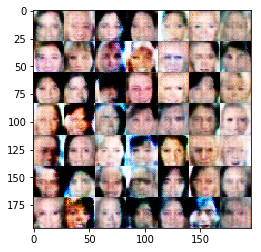

Epoch: 1 of 1	 Discriminator Loss: 0.490173	 Generator Loss: 2.532573
Epoch: 1 of 1	 Discriminator Loss: 0.489256	 Generator Loss: 2.748200
Epoch: 1 of 1	 Discriminator Loss: 0.500317	 Generator Loss: 3.275913
Epoch: 1 of 1	 Discriminator Loss: 0.725486	 Generator Loss: 5.252402
Epoch: 1 of 1	 Discriminator Loss: 0.494189	 Generator Loss: 3.756990
Epoch: 1 of 1	 Discriminator Loss: 1.645591	 Generator Loss: 0.370378
Epoch: 1 of 1	 Discriminator Loss: 0.690549	 Generator Loss: 2.716697
Epoch: 1 of 1	 Discriminator Loss: 0.543521	 Generator Loss: 2.023612
Epoch: 1 of 1	 Discriminator Loss: 0.437864	 Generator Loss: 2.886087
Epoch: 1 of 1	 Discriminator Loss: 0.886201	 Generator Loss: 5.339858


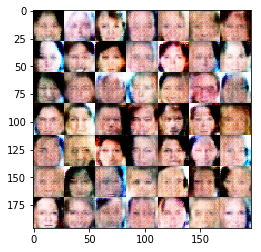

Epoch: 1 of 1	 Discriminator Loss: 0.867295	 Generator Loss: 1.062528
Epoch: 1 of 1	 Discriminator Loss: 0.432583	 Generator Loss: 3.082277
Epoch: 1 of 1	 Discriminator Loss: 0.513243	 Generator Loss: 4.019508
Epoch: 1 of 1	 Discriminator Loss: 0.537406	 Generator Loss: 2.005748
Epoch: 1 of 1	 Discriminator Loss: 0.402866	 Generator Loss: 4.306784
Epoch: 1 of 1	 Discriminator Loss: 2.414729	 Generator Loss: 3.506743
Epoch: 1 of 1	 Discriminator Loss: 0.539756	 Generator Loss: 2.147314
Epoch: 1 of 1	 Discriminator Loss: 0.719898	 Generator Loss: 3.755218
Epoch: 1 of 1	 Discriminator Loss: 0.592892	 Generator Loss: 1.819645
Epoch: 1 of 1	 Discriminator Loss: 0.692370	 Generator Loss: 5.542132


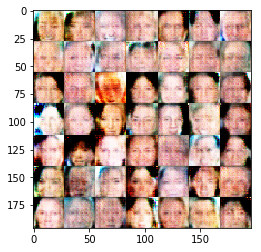

Epoch: 1 of 1	 Discriminator Loss: 0.452976	 Generator Loss: 2.964504
Epoch: 1 of 1	 Discriminator Loss: 0.649151	 Generator Loss: 2.859965
Epoch: 1 of 1	 Discriminator Loss: 0.589841	 Generator Loss: 1.854400
Epoch: 1 of 1	 Discriminator Loss: 0.910239	 Generator Loss: 3.264441
Epoch: 1 of 1	 Discriminator Loss: 0.577617	 Generator Loss: 2.957199
Epoch: 1 of 1	 Discriminator Loss: 0.748062	 Generator Loss: 5.464670
Epoch: 1 of 1	 Discriminator Loss: 0.970915	 Generator Loss: 2.690906
Epoch: 1 of 1	 Discriminator Loss: 0.607949	 Generator Loss: 1.821725
Epoch: 1 of 1	 Discriminator Loss: 1.132788	 Generator Loss: 4.208028
Epoch: 1 of 1	 Discriminator Loss: 0.655669	 Generator Loss: 1.548889


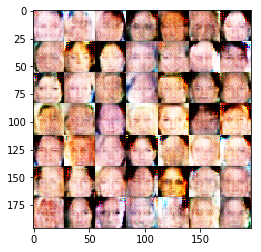

Epoch: 1 of 1	 Discriminator Loss: 1.436861	 Generator Loss: 3.858532
Epoch: 1 of 1	 Discriminator Loss: 0.494303	 Generator Loss: 2.190265
Epoch: 1 of 1	 Discriminator Loss: 0.441713	 Generator Loss: 3.046363
Epoch: 1 of 1	 Discriminator Loss: 1.605352	 Generator Loss: 5.083565
Epoch: 1 of 1	 Discriminator Loss: 1.413866	 Generator Loss: 0.570844
Epoch: 1 of 1	 Discriminator Loss: 0.631811	 Generator Loss: 2.088324
Epoch: 1 of 1	 Discriminator Loss: 0.778727	 Generator Loss: 1.895481
Epoch: 1 of 1	 Discriminator Loss: 0.593327	 Generator Loss: 3.180562
Epoch: 1 of 1	 Discriminator Loss: 0.532555	 Generator Loss: 2.211725
Epoch: 1 of 1	 Discriminator Loss: 1.377292	 Generator Loss: 3.549327


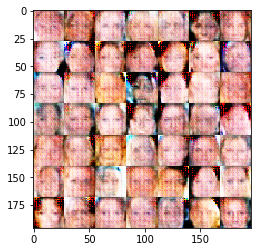

Epoch: 1 of 1	 Discriminator Loss: 0.506244	 Generator Loss: 2.502923
Epoch: 1 of 1	 Discriminator Loss: 0.656512	 Generator Loss: 2.226759
Epoch: 1 of 1	 Discriminator Loss: 1.276804	 Generator Loss: 4.476129
Epoch: 1 of 1	 Discriminator Loss: 0.507485	 Generator Loss: 2.560773
Epoch: 1 of 1	 Discriminator Loss: 1.246957	 Generator Loss: 5.272910
Epoch: 1 of 1	 Discriminator Loss: 0.497577	 Generator Loss: 2.492836
Epoch: 1 of 1	 Discriminator Loss: 0.667232	 Generator Loss: 1.519729
Epoch: 1 of 1	 Discriminator Loss: 0.534322	 Generator Loss: 2.067297
Epoch: 1 of 1	 Discriminator Loss: 1.193879	 Generator Loss: 1.321287
Epoch: 1 of 1	 Discriminator Loss: 0.494445	 Generator Loss: 2.959872


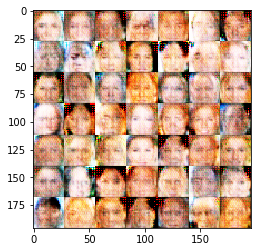

Epoch: 1 of 1	 Discriminator Loss: 0.571698	 Generator Loss: 4.816917
Epoch: 1 of 1	 Discriminator Loss: 0.529840	 Generator Loss: 2.335589
Epoch: 1 of 1	 Discriminator Loss: 1.564664	 Generator Loss: 0.417762
Epoch: 1 of 1	 Discriminator Loss: 0.495415	 Generator Loss: 2.530425
Epoch: 1 of 1	 Discriminator Loss: 0.514130	 Generator Loss: 2.363212
Epoch: 1 of 1	 Discriminator Loss: 0.511532	 Generator Loss: 3.134899
Epoch: 1 of 1	 Discriminator Loss: 0.962113	 Generator Loss: 3.859488
Epoch: 1 of 1	 Discriminator Loss: 0.992990	 Generator Loss: 1.037372
Epoch: 1 of 1	 Discriminator Loss: 1.188227	 Generator Loss: 3.262192
Epoch: 1 of 1	 Discriminator Loss: 1.615492	 Generator Loss: 0.394514


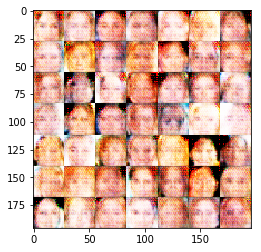

Epoch: 1 of 1	 Discriminator Loss: 0.494520	 Generator Loss: 3.001724
Epoch: 1 of 1	 Discriminator Loss: 0.485853	 Generator Loss: 3.085265
Epoch: 1 of 1	 Discriminator Loss: 0.770022	 Generator Loss: 2.330605
Epoch: 1 of 1	 Discriminator Loss: 2.897242	 Generator Loss: 0.152250
Epoch: 1 of 1	 Discriminator Loss: 0.592716	 Generator Loss: 2.197468
Epoch: 1 of 1	 Discriminator Loss: 0.701425	 Generator Loss: 3.438869
Epoch: 1 of 1	 Discriminator Loss: 0.893337	 Generator Loss: 3.804506
Epoch: 1 of 1	 Discriminator Loss: 0.605165	 Generator Loss: 2.857396
Epoch: 1 of 1	 Discriminator Loss: 1.516518	 Generator Loss: 0.440329
Epoch: 1 of 1	 Discriminator Loss: 0.893649	 Generator Loss: 4.736978


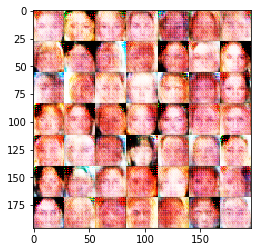

Epoch: 1 of 1	 Discriminator Loss: 0.547638	 Generator Loss: 4.367366
Epoch: 1 of 1	 Discriminator Loss: 1.007768	 Generator Loss: 0.960630
Epoch: 1 of 1	 Discriminator Loss: 1.071884	 Generator Loss: 0.810708
Epoch: 1 of 1	 Discriminator Loss: 0.523672	 Generator Loss: 3.342525
Epoch: 1 of 1	 Discriminator Loss: 0.872695	 Generator Loss: 1.044133
Epoch: 1 of 1	 Discriminator Loss: 0.974323	 Generator Loss: 0.906019
Epoch: 1 of 1	 Discriminator Loss: 0.871512	 Generator Loss: 1.111483
Epoch: 1 of 1	 Discriminator Loss: 0.920195	 Generator Loss: 1.006292
Epoch: 1 of 1	 Discriminator Loss: 0.478929	 Generator Loss: 2.522472
Epoch: 1 of 1	 Discriminator Loss: 0.465129	 Generator Loss: 2.551869


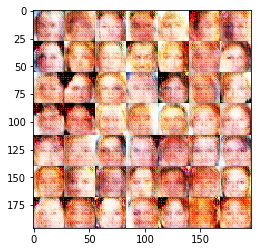

Epoch: 1 of 1	 Discriminator Loss: 0.463378	 Generator Loss: 2.598441
Epoch: 1 of 1	 Discriminator Loss: 1.842472	 Generator Loss: 2.482320
Epoch: 1 of 1	 Discriminator Loss: 1.237664	 Generator Loss: 0.666990
Epoch: 1 of 1	 Discriminator Loss: 0.583903	 Generator Loss: 1.895120
Epoch: 1 of 1	 Discriminator Loss: 1.176435	 Generator Loss: 0.670491
Epoch: 1 of 1	 Discriminator Loss: 0.521725	 Generator Loss: 2.267693
Epoch: 1 of 1	 Discriminator Loss: 0.663821	 Generator Loss: 1.518258
Epoch: 1 of 1	 Discriminator Loss: 1.335592	 Generator Loss: 4.270822
Epoch: 1 of 1	 Discriminator Loss: 0.791631	 Generator Loss: 1.278447
Epoch: 1 of 1	 Discriminator Loss: 1.045357	 Generator Loss: 2.125871


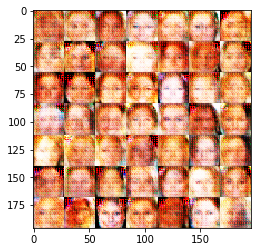

Epoch: 1 of 1	 Discriminator Loss: 0.508457	 Generator Loss: 2.962716
Epoch: 1 of 1	 Discriminator Loss: 0.449388	 Generator Loss: 2.742146
Epoch: 1 of 1	 Discriminator Loss: 0.897277	 Generator Loss: 2.879474
Epoch: 1 of 1	 Discriminator Loss: 0.810352	 Generator Loss: 1.188524
Epoch: 1 of 1	 Discriminator Loss: 0.486254	 Generator Loss: 2.580935
Epoch: 1 of 1	 Discriminator Loss: 0.572955	 Generator Loss: 1.791853
Epoch: 1 of 1	 Discriminator Loss: 0.604305	 Generator Loss: 1.725167
Epoch: 1 of 1	 Discriminator Loss: 0.501673	 Generator Loss: 2.405409
Epoch: 1 of 1	 Discriminator Loss: 0.528130	 Generator Loss: 3.234910
Epoch: 1 of 1	 Discriminator Loss: 0.586745	 Generator Loss: 3.005612


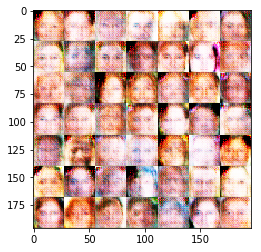

Epoch: 1 of 1	 Discriminator Loss: 2.545880	 Generator Loss: 0.272337
Epoch: 1 of 1	 Discriminator Loss: 0.806533	 Generator Loss: 1.732385
Epoch: 1 of 1	 Discriminator Loss: 0.764436	 Generator Loss: 1.340073
Epoch: 1 of 1	 Discriminator Loss: 0.555347	 Generator Loss: 2.675684
Epoch: 1 of 1	 Discriminator Loss: 1.366511	 Generator Loss: 0.559480
Epoch: 1 of 1	 Discriminator Loss: 0.979067	 Generator Loss: 1.093776
Epoch: 1 of 1	 Discriminator Loss: 0.498407	 Generator Loss: 3.012498
Epoch: 1 of 1	 Discriminator Loss: 1.778370	 Generator Loss: 0.392869


In [35]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.